In [1]:
from differentiable_lensing import DifferentiableLensing
import torch
import matplotlib.pyplot as plt

Initialising the DifferentiableLensing module to a lower resolution for the purposes of demonstration

In [2]:
downscale_fraction = 4*8
grid_shape = 256//downscale_fraction
lensing_module = DifferentiableLensing('cpu', target_resolution=0.101*downscale_fraction, target_shape=grid_shape, alpha=None)

Initialising the deflection field

In [3]:
alpha_r = 3
theta_x, theta_y, theta_x_as, theta_y_as = lensing_module.make_center_grid(-0.101*downscale_fraction * grid_shape / 2.0, 0.101*downscale_fraction * grid_shape / 2.0, grid_shape)
theta_x_as, theta_y_as = theta_x_as.unsqueeze(0), theta_y_as.unsqueeze(0)
alpha = lensing_module.construct_sis(theta_x_as, theta_y_as, alpha_r)
beta_x, beta_y = lensing_module.backward_lensing(theta_x_as, theta_y_as, alpha)

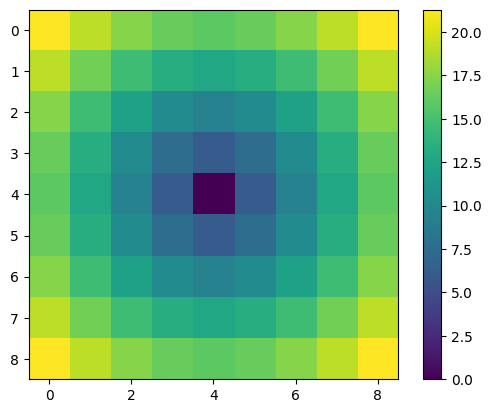

In [4]:
beta_r = (beta_x**2 + beta_y**2).sqrt()
plt.imshow(beta_r[0])
plt.colorbar()

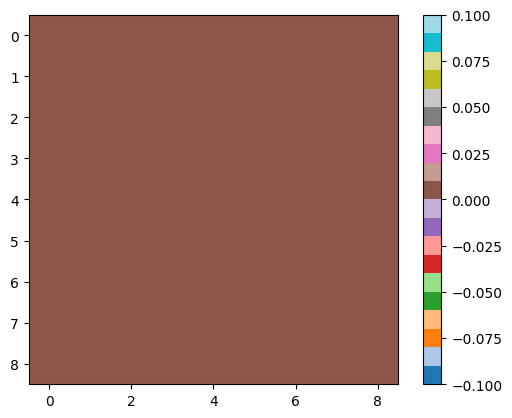

In [5]:
beta_r_flip = beta_r.flip(dims=[-1])
beta_r_flip_2 = beta_r.flip(dims=[-2])
plt.imshow((beta_r_flip[0] - beta_r[0]).abs() + (beta_r_flip_2[0] - beta_r[0]).abs(), cmap='tab20')
plt.colorbar()

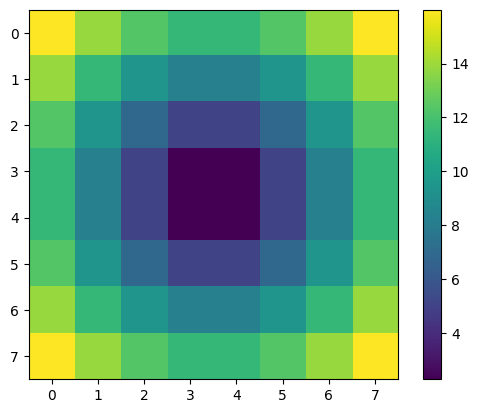

In [6]:
theta_r = (theta_x**2 + theta_y**2).sqrt()
plt.imshow(theta_r)
plt.colorbar()

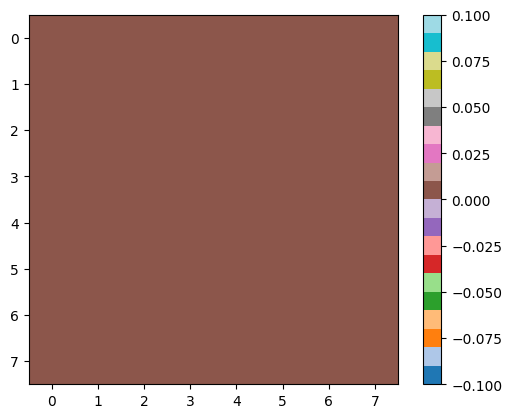

In [7]:
theta_r_flip = theta_r.flip(dims=[-1])
theta_r_flip_2 = theta_r.flip(dims=[-2])
plt.imshow((theta_r_flip - theta_r).abs() + (theta_r_flip_2 - theta_r).abs(), cmap='tab20')
plt.colorbar()

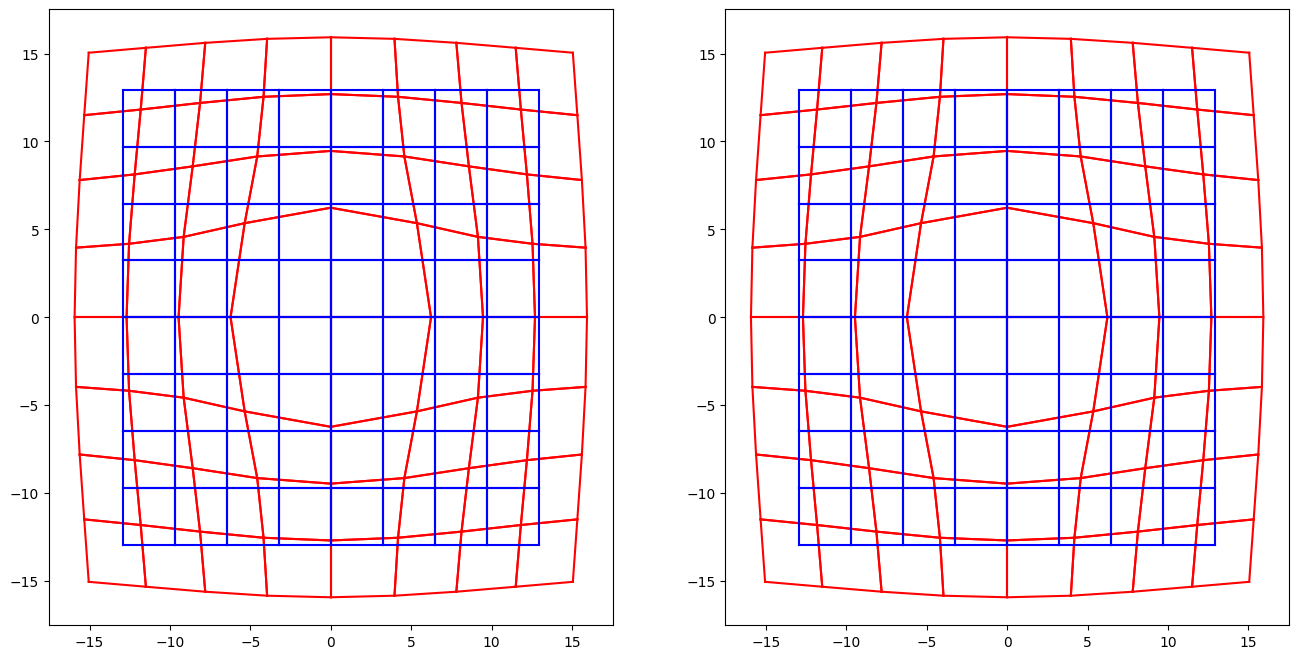

In [8]:
plot, axes = plt.subplots(1,2)
plot.set_size_inches(16, 8)
beta_x, beta_y = beta_x[0], beta_y[0]
theta_x_as, theta_y_as = theta_x_as[0], theta_y_as[0]
axes[0].plot([beta_x[1:, :-1].flatten(), beta_x[1:, 1:].flatten()], [beta_y[1:, :-1].flatten(), beta_y[1:, 1:].flatten()], c='red')
axes[0].plot([beta_x[1:, 1:].flatten(), beta_x[:-1, 1:].flatten()], [beta_y[1:, 1:].flatten(), beta_y[:-1, 1:].flatten()], c='red')
axes[0].plot([beta_x[:-1, 1:].flatten(), beta_x[:-1, :-1].flatten()], [beta_y[:-1, 1:].flatten(), beta_y[:-1, :-1].flatten()], c='red')
axes[0].plot([beta_x[:-1, :-1].flatten(), beta_x[1:, :-1].flatten()], [beta_y[:-1, :-1].flatten(), beta_y[1:, :-1].flatten()], c='red')
theta_x_left = theta_x - 1/2 * lensing_module.pixel_width
theta_x_right = theta_x + 1/2 * lensing_module.pixel_width
theta_y_left = theta_y - 1/2 * lensing_module.pixel_width
theta_y_right = theta_y + 1/2 * lensing_module.pixel_width
theta_x_left = theta_x_left.flatten()
theta_x_right = theta_x_right.flatten()
theta_y_left = theta_y_left.flatten()
theta_y_right = theta_y_right.flatten()
axes[0].plot([theta_x_left, theta_x_right], [theta_y_left, theta_y_left], c='blue')
axes[0].plot([theta_x_right, theta_x_right], [theta_y_left, theta_y_right], c='blue')
axes[0].plot([theta_x_right, theta_x_left], [theta_y_right, theta_y_right], c='blue')
axes[0].plot([theta_x_left, theta_x_left], [theta_y_right, theta_y_left], c='blue')

axes[1].plot([beta_x[1:, :-1].flatten(), beta_x[1:, 1:].flatten()], [beta_y[1:, :-1].flatten(), beta_y[1:, 1:].flatten()], c='red')
axes[1].plot([beta_x[1:, 1:].flatten(), beta_x[:-1, 1:].flatten()], [beta_y[1:, 1:].flatten(), beta_y[:-1, 1:].flatten()], c='red')
axes[1].plot([beta_x[:-1, 1:].flatten(), beta_x[:-1, :-1].flatten()], [beta_y[:-1, 1:].flatten(), beta_y[:-1, :-1].flatten()], c='red')
axes[1].plot([beta_x[:-1, :-1].flatten(), beta_x[1:, :-1].flatten()], [beta_y[:-1, :-1].flatten(), beta_y[1:, :-1].flatten()], c='red')

axes[1].plot([theta_x_as[1:, :-1].flatten(), theta_x_as[1:, 1:].flatten()], [theta_y_as[1:, :-1].flatten(), theta_y_as[1:, 1:].flatten()], c='blue')
axes[1].plot([theta_x_as[1:, 1:].flatten(), theta_x_as[:-1, 1:].flatten()], [theta_y_as[1:, 1:].flatten(), theta_y_as[:-1, 1:].flatten()], c='blue')
axes[1].plot([theta_x_as[:-1, 1:].flatten(), theta_x_as[:-1, :-1].flatten()], [theta_y_as[:-1, 1:].flatten(), theta_y_as[:-1, :-1].flatten()], c='blue')
axes[1].plot([theta_x_as[:-1, :-1].flatten(), theta_x_as[1:, :-1].flatten()], [theta_y_as[:-1, :-1].flatten(), theta_y_as[1:, :-1].flatten()], c='blue')
print()

In [9]:
# grid_fracs = lensing_module.square_grid_crop(theta_x, theta_y, beta_x, beta_y)
grid_fracs = lensing_module.log_grid_crop(theta_x_as, theta_y_as, beta_x, beta_y)

Iterating through axis-oriented grid rows: 100%|██████████| 8/8 [00:00<00:00, 14.50it/s]


Save the computed cross-grid fractional area overlaps

In [10]:
# torch.save(grid_fracs, 'grid_fracs.pt')

Compute the area of each cell in the distorted grid for intensity normalisation

In [11]:
As = lensing_module.nsq_As(beta_x, beta_y)

In [12]:
M, shape = lensing_module.build_sparse_mapping(grid_fracs, As, 'cpu')

Save the sparse coo matrix for the cross-grid fractional area overlaps

In [13]:
# torch.save(M, 'sparse_grid_fracs_euclid_backward_2.pt')
torch.save(M, 'small_crop.pt')